In [ ]:
# Setting up the enviornment
# Required python packages that need to be installed

"""
!conda create --name path_session -y
!conda activate path_session
!conda install pip ipykernel large-image large-image-source-tiff -y
!conda install pandas -y
!ipython kernel install --user --name=path_session
!pip install large-image-source-tifffile patchify opencv-python albumentations
"""
# IMPORTANT: Please restart the kernel before importing python packages

# Download the required data from camelyon website - download the file directly from the repository
# wget https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100439/CAMELYON16/training/tumor/tumor_058.tif -O ./[customPath]/tumor_058.tif
# http://gigadb.org/dataset/view/id/100439

# Location of the CAMELYON  WSIs: /CAMELYON16/training/tumor/tumor_058.tif
# Location of the CAMELYON  annotations: /CAMELYON16/training/lesion_annotations/tumor_058.xml

In [1]:
# Import packages for managing files
import os
from pathlib import Path
import glob

# Import packages for working with RGB images
import cv2
import numpy as np
import skimage.io as skio
from PIL import Image
from patchify import patchify, unpatchify

# Import packages for data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Import packages for working with whole slide images
import large_image

# Import packages for data processing
import pandas as pd
import xml.etree.ElementTree as et

# Supress Warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Helper functions

# This function takes a list as input and removed any duplicate elements
def Remove(duplicate):
    final_list = []
    for num in duplicate:
        if num not in final_list:
            final_list.append(num)
    return final_list


# This function converts lists of list to a single list
def flatList(listoflist):
    return [item for elem in listoflist for item in elem]


# Convert Camelyon ground truth daya which is in xml format to a dataframe
def convert_xml_df (file):
    parseXML = et.parse(file)
    root = parseXML.getroot()
    dfcols_1 = ['Order', 'X', 'Y']
    dfcols_2 = ['Name', 'Type', 'Group', 'Color']
    df_xml_1 = pd.DataFrame(columns=dfcols_1)
    df_xml_2 = pd.DataFrame(columns=dfcols_2)
    for child in root.iter('Annotations'):
        for coordinate in child.iter('Coordinate'):
            Order = coordinate.attrib.get('Order')
            X_coord = float(coordinate.attrib.get('X'))
            X_coord = ((X_coord)*dims[0])/Ximageorg
            Y_coord = float(coordinate.attrib.get('Y'))
            Y_coord = ((Y_coord)*dims[1])/Yimageorg
            df_xml_1 = df_xml_1.append(pd.Series([Order, X_coord, Y_coord], index = dfcols_1), ignore_index=True)
        df_xml_1 = pd.DataFrame(df_xml_1)   

    for parent in root.iter('Annotations'):
        for child in root.iter('Annotation'):
            for coordinate in child.iter('Coordinate'):
                Name = child.attrib.get('Name')
                Type = child.attrib.get('Type')
                Group = child.attrib.get('PartOfGroup')
                Color = child.attrib.get('Color')
                df_xml_2 = df_xml_2.append(pd.Series([Name, Type, Group, Color], index = dfcols_2), ignore_index=True)
    
    finaldf =  pd.concat([df_xml_1, df_xml_2], axis=1)
    return (finaldf)  



In [3]:
# Set the required path containing the Camelyon dataset

#rootDir = os.getcwd()
#slideDir = rootDir+"/camelyonData/WSI/tumor_058.tif"
#annotDir =  rootDir+"/camelyonData/annot/tumor_058.xml"



slideDir = "/CAMELYON16/training/tumor/tumor_058.tif"
annotDir = "/CAMELYON16/training/lesion_annotations/tumor_058.xml"

In [4]:
# Extract basename from the path string
wsiFileName = Path(slideDir).stem
annotFileName = Path(annotDir).stem

### What is Whole Slide Imaging?
The term “whole slide imaging” refers to the conversion of an entire microscope slide into a digital image that can be viewed on a computer screen. Whole slide images are captured using a “whole slide scanner”, which is essentially a high-end microscope with a built-in camera that is specifically designed to efficiently capture these images. 
The scanner captures whole slide images in a series of smaller “tiles” that are digitally “stitched” together into a high-resolution image of the entire slide. This allows researchers and pathologists to view these images on a computer screen with the same magnification with which they would view a slide under a microscope. 
There are many advantages of whole slide images versus maintaining a library of glass slides, but there are also challenges to consider when implementing whole slide imaging technologies.


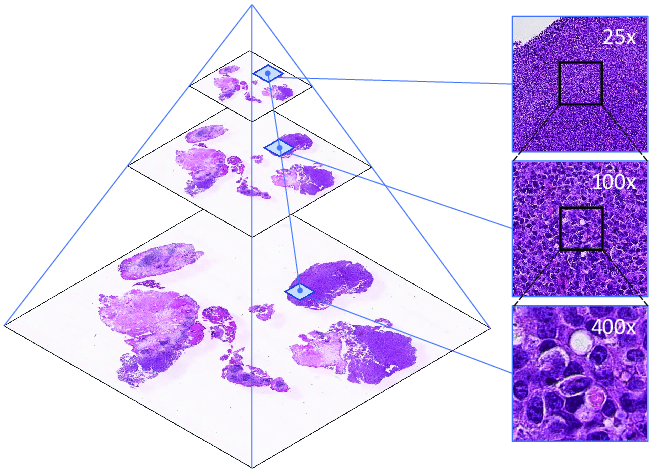

In [5]:
# Set tilesource of the our WSI
# Get level value using magnification information

ts = large_image.getTileSource(slideDir)

# Get the magnification associated with all levels of the image pyramid
for i in range(ts.levels):
    print('Level-{} : {}'.format(
        i, ts.getMagnificationForLevel(level=i)))

Level-0 : {'magnification': 0.08034443466313443, 'mm_x': 0.124464128, 'mm_y': 0.124464128, 'scale': 512.0, 'level': 0}
Level-1 : {'magnification': 0.16068886932626886, 'mm_x': 0.062232064, 'mm_y': 0.062232064, 'scale': 256.0, 'level': 1}
Level-2 : {'magnification': 0.3213777386525377, 'mm_x': 0.031116032, 'mm_y': 0.031116032, 'scale': 128.0, 'level': 2}
Level-3 : {'magnification': 0.6427554773050754, 'mm_x': 0.015558016, 'mm_y': 0.015558016, 'scale': 64.0, 'level': 3}
Level-4 : {'magnification': 1.2855109546101509, 'mm_x': 0.007779008, 'mm_y': 0.007779008, 'scale': 32.0, 'level': 4}
Level-5 : {'magnification': 2.5710219092203017, 'mm_x': 0.003889504, 'mm_y': 0.003889504, 'scale': 16.0, 'level': 5}
Level-6 : {'magnification': 5.142043818440603, 'mm_x': 0.001944752, 'mm_y': 0.001944752, 'scale': 8.0, 'level': 6}
Level-7 : {'magnification': 10.284087636881207, 'mm_x': 0.000972376, 'mm_y': 0.000972376, 'scale': 4.0, 'level': 7}
Level-8 : {'magnification': 20.568175273762414, 'mm_x': 0.0004

(2377, 5377)


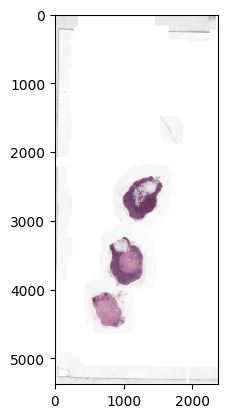

In [6]:

# Load WSI data
# RESOURCE: https://digitalslidearchive.github.io/HistomicsTK/examples/using_large_image.html
magnificationVal = 1
slide, _ = ts.getRegion(scale=dict(magnification = magnificationVal), format=large_image.tilesource.TILE_FORMAT_PIL)

print(slide.size)

# Plot WSI
plt.imshow(slide)

In [7]:
# Get details of whole slide image using the avilable metadata

OriginalDetails = ts.getMetadata()

In [8]:
# Load annotation details as a dataframe

dims = slide.size
Ximageorg, Yimageorg = OriginalDetails['sizeX'], OriginalDetails['sizeY'] 

annotations = convert_xml_df(annotDir)

In [9]:
# Explore annotation data in the dataframe
annotations.head(n=5)

,Order,X,Y,Name,Type,Group,Color
0,0,1225.842371,2652.788497,_0,Polygon,_0,#F4FA58
1,1,1225.730560,2652.666947,_0,Polygon,_0,#F4FA58
2,2,1225.399989,2652.666947,_0,Polygon,_0,#F4FA58
3,3,1225.069418,2652.666947,_0,Polygon,_0,#F4FA58
4,4,1224.848227,2652.569707,_0,Polygon,_0,#F4FA58


In [10]:
# Check the total unique annotations available
annotations.Name.unique()

array(['_0', '_1', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10',
       '_11', '_12', '_13', '_14'], dtype=object)

In [11]:
# Export dataframe to a csv file
annotations.to_csv('AnnotDF.csv')

In [12]:
# Sanity Check: Remove any duplicate annotations

final_list = Remove(annotations['Name'])

coxy = [[] for x in range(len(final_list))]

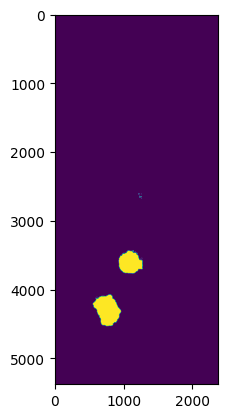

In [13]:
# Generate binary mask files

coxy = [[] for x in range(len(final_list))]

i = 0
for n in final_list:
    newx = annotations[annotations['Name']== n]['X']
    newy = annotations[annotations['Name']== n]['Y']
    #print(n)
    #print(newx, newy)
    newxy = list(zip(newx, newy))
    coxy[i] = np.array(newxy, dtype=np.int32)
    i=i+1

# Apply annotations over an empty mask file
maskImg = np.zeros((dims[1],dims[0]), np.uint8)  

for i in range(len(coxy)):
    cv2.fillConvexPoly(maskImg, coxy[i], (255, 255))
    
# Plot mask data

plt.imshow(maskImg)

## Extract patches using 'Patchify'
#### Link: https://pypi.org/project/patchify/

* Split images into fixed size patches
* This library provides two functions: patchify, unpatchify

### Patchify requirement:
* Size (length and width) of the original image should satisfy the following condition: 
    * wsiWidth % patchWidth = 0
    * wsiHeight % patchHeight = 0 

In [14]:
# Check if the input WSI/Mask meets the required criteria
patchSizeH = 256
patchSizeW = 256

print("WSI Dimensions: "+str(dims))

print("wsiWidth % patchWidth: "+str(dims[0]%patchSizeW))

print("wsiHeight % patchHeight: "+str(dims[1]%patchSizeH))

WSI Dimensions: (2377, 5377)
wsiWidth % patchWidth: 73
wsiHeight % patchHeight: 1


In [15]:
# Pad original images so that it meets the patchify criteria
baseimgsize = (patchSizeH, patchSizeW)

if dims[0] and dims[1] <  5120:
    baseimgsize = (5120, 5120) 
elif dims[0] and dims[1] <  7680:
    baseimgsize = (7680, 7680)
elif dims[0] and dims[1] <  10240:
    baseimgsize = (10240, 10240)
    
basewsiimg = Image.new("RGB", baseimgsize, (0, 0, 0))

basewsiimg.paste(slide)

GTShape = basewsiimg.size

wsi_arr = np.array(basewsiimg)

print("Padded WSI Dimensions: "+str(GTShape))
    
print("Padded wsiWidth % patchWidth: "+str(GTShape[0]%patchSizeW))

print("Padded wsiHeight % patchHeight: "+str(GTShape[1]%patchSizeH))


Padded WSI Dimensions: (7680, 7680)
Padded wsiWidth % patchWidth: 0
Padded wsiHeight % patchHeight: 0


In [16]:
# Repeat the same process for the Mask file
basemaskimg = Image.new("L", baseimgsize)

basemaskimg.paste(Image.fromarray(maskImg))

mask_arr = np.array(basemaskimg)

masks_img = patchify(mask_arr, (patchSizeH, patchSizeW), step=256)  #Step=256 for 256 patches means no overlap

print("Padded Mask Dimensions: "+str(GTShape))
    
print("Padded maskWidth % patchWidth: "+str(GTShape[0]%patchSizeW))

print("Padded maskHeight % patchHeight: "+str(GTShape[1]%patchSizeH))


Padded Mask Dimensions: (7680, 7680)
Padded maskWidth % patchWidth: 0
Padded maskHeight % patchHeight: 0


In [17]:
# Extract patches from both WSI and mask images and save them in their respective folders -- using Patchify

WSIPatches_Loc = "./patches/"
MaskPatches_Loc = "./masks/"
channels = 3

# Check of 'patches' and 'masks' folder exists, if not create it
if os.path.isdir(WSIPatches_Loc) == False:
    os.makedirs(WSIPatches_Loc)

if os.path.isdir(MaskPatches_Loc) == False:
    os.makedirs(MaskPatches_Loc)
    

# Extracting wsi patches using patchify
patches_img = patchify(wsi_arr, (patchSizeH, patchSizeH, channels), step=256)

patchCount = 0

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i,j,:,:]
        singlepngimg = single_patch_img[0,:,:,:]
        cv2.imwrite(WSIPatches_Loc+wsiFileName+"_"+"patch_"+str(patchCount)+".png", cv2.cvtColor(singlepngimg, cv2.COLOR_BGR2RGB))
        patchCount += 1

print("Total WSI Patches: "+str(len(os.listdir(WSIPatches_Loc))))

# Extracting mask patches  using patchify
patchCount = 0

for i in range(masks_img.shape[0]):
    for j in range(masks_img.shape[1]):
        single_patch_img = masks_img[i,j,:]
        #singlepngimg = single_patch_img[0,:,:]
        cv2.imwrite(MaskPatches_Loc+annotFileName+"_"+"patch_"+str(patchCount)+".png", single_patch_img)
        patchCount += 1
print("Total Mask Patches: "+str(len(os.listdir(WSIPatches_Loc))))

Total WSI Patches: 900
Total Mask Patches: 900


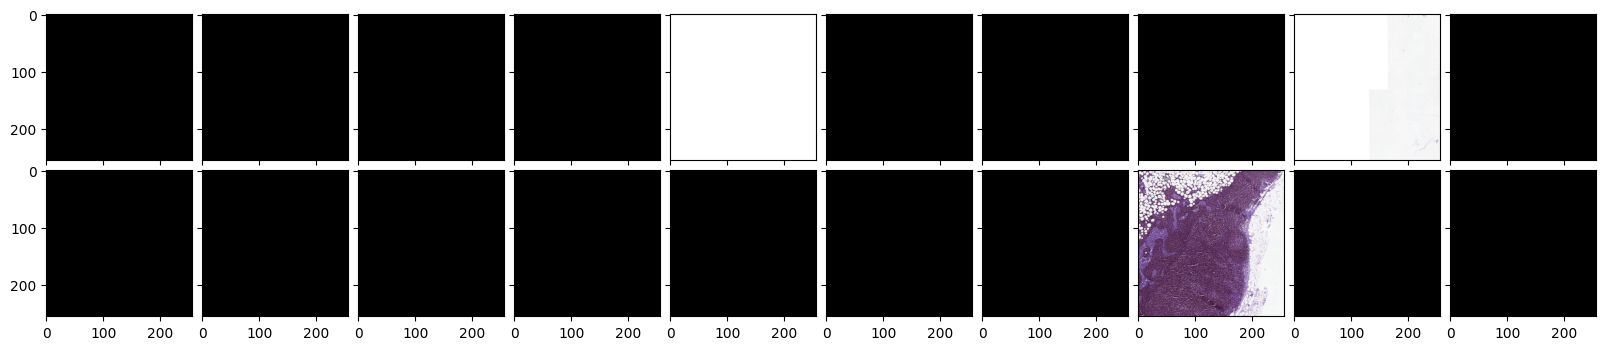

In [18]:
# Dsiplay multiple patches as a grid

imglimit = 20
nrows = 2
ncols = 10

images = []
for img_path in glob.glob(WSIPatches_Loc+"*.png"):
    img = cv2.imread(img_path)
    images.append(img)

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(nrows, ncols),  # creates rowsxcols grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

In [19]:
# Remove patches that do not have useful information
imgDir = os.listdir(WSIPatches_Loc)

count = 0

for imgD in imgDir:
    actualIMG = cv2.imread(WSIPatches_Loc+imgD, 0)
    actualMask = cv2.imread(MaskPatches_Loc+imgD)
    # Remove patches where there is no major tissue region
    # Remove all empty patches
    if(np.mean(actualIMG[:,:])>200) or cv2.countNonZero(actualIMG) == 0 or (np.mean(actualIMG[:,:])<100):
        if actualMask.all() != 0:
            pass
        else:
            os.remove(WSIPatches_Loc+imgD)
            os.remove(MaskPatches_Loc+imgD)
            count +=1
        
print("Total patches that were removed: "+ str(count))

remainingPatches = len(imgDir) - count
print("Total patches remaining: "+ str(remainingPatches))

Total patches that were removed: 888
Total patches remaining: 12


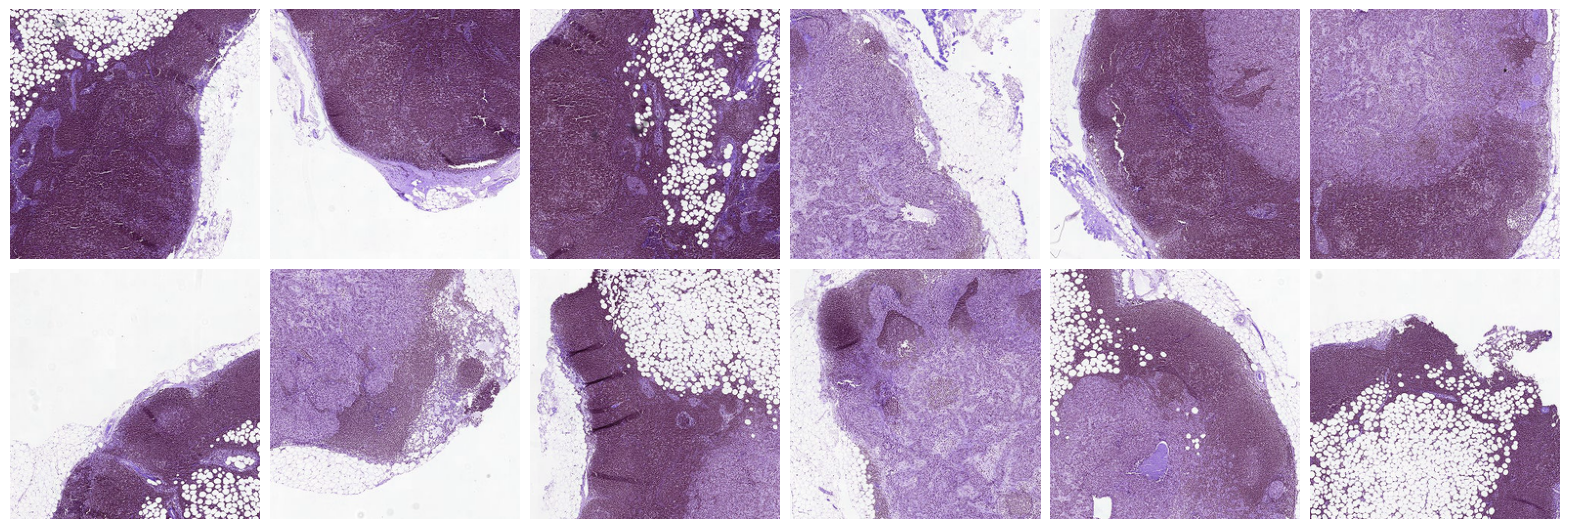

In [20]:
# Display multiple patches as a grid

nrows = 2
ncols = 6

images = []
for img_path in glob.glob(WSIPatches_Loc+"*.png"):
    img = cv2.imread(img_path)
    images.append(img)

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(nrows, ncols),  # creates rowsxcols grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.set_axis_off()

plt.show()

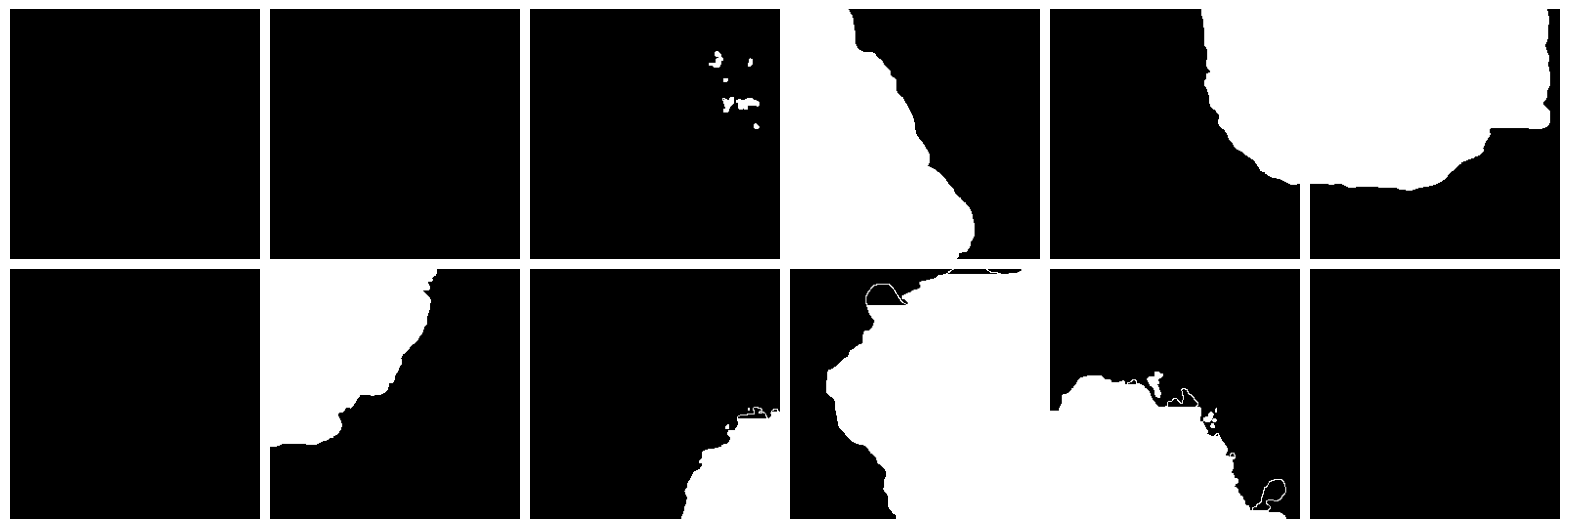

In [21]:
# Display multiple masks as a grid

nrows = 2
ncols = 6

images = []
for img_path in glob.glob(MaskPatches_Loc+"*.png"):
    img = cv2.imread(img_path)
    images.append(img)

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(nrows, ncols),  # creates rowsxcols grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.set_axis_off()

plt.show()

In [22]:
# Fill any holes in the binary masks
def FillHole(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len_contour = len (contours)
    contour_list = []
    for i in range(len_contour):
        drawing = np.zeros_like(mask, np.uint8)  # create a black image
        img_contour = cv2.drawContours(drawing, contours, i, (255, 255, 255), -1)
        contour_list.append(img_contour)

    out = sum(contour_list)
    return out


imageList = os.listdir(MaskPatches_Loc)

for Simage in imageList:
    mask_in = cv2.imread(MaskPatches_Loc+Simage, 0)
    if len(np.unique(mask_in)) == 2:
        mask_out = FillHole(mask_in)
        cv2.imwrite(MaskPatches_Loc+Simage, mask_out)

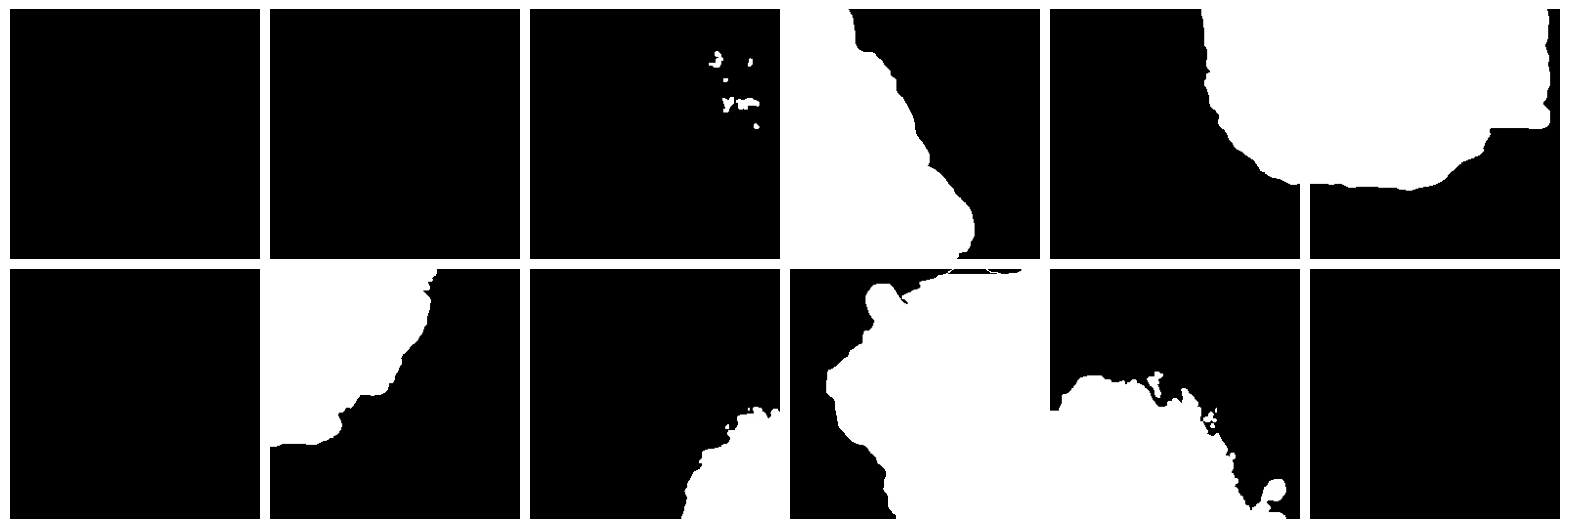

In [23]:
# Display multiple masks as a grid

nrows = 2
ncols = 6

images = []
for img_path in glob.glob(MaskPatches_Loc+"*.png"):
    img = cv2.imread(img_path)
    images.append(img)

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(nrows, ncols),  # creates rowsxcols grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.set_axis_off()

plt.show()

In [24]:
# Check if the pixel values in the mask files are indeed binary if not correct it

for img_path in glob.glob(MaskPatches_Loc+"*.png"):
    img = cv2.imread(img_path)
    
    #img[img>0] = 255
    
    if (len(np.unique(img))>2):
        print(np.unique(img))
    elif (len(np.unique(img))==2):
        print(Path(img_path).stem+ " mask is binary!")


[  0 254 255]
tumor_058_patch_483 mask is binary!
tumor_058_patch_423 mask is binary!
tumor_058_patch_424 mask is binary!
tumor_058_patch_513 mask is binary!
[  0 253 254 255]
[  0 254 255]
[  0 254 255]


In [ ]:
"""
# Stain normalizarion
# Installing spams on windows:
# 1. Go to: https://github.com/samuelstjean/spams-python/releases/tag/v2.6.1
# 2. Download .whl file for the required python version
# 3. pip install downloaded .whl file path
# 4. pip install spams-bin

# part2: stain conversion with a reference image using vahadane method
import os
import skimage.io as skio
import staintools

inputDir = "./inputDir"
outputDir = "./outDir"
errorDir = "./stainFailed"
images = os.listdir(inputDir)

for image in images:
    #Read data
    target = staintools.read_image("Target_Patch.png")  # reference image that all WSIs will be transformed to
    to_transform = staintools.read_image(inputDir+"/{}".format(image))
    try:

        # Standardize brightness (optional, can improve the tissue mask calculation)
        target = staintools.LuminosityStandardizer.standardize(target)
        to_transform = staintools.LuminosityStandardizer.standardize(to_transform)

        # Stain normalize
        normalizer = staintools.StainNormalizer(method='vahadane')
        normalizer.fit(target)
        transformed = normalizer.transform(to_transform)

        #In skimage images, the red channel is specified first, then the green, then the blue, i.e., RGB.

        skio.imsave(outputDir+"/{}".format(image),transformed)
    except:
        skio.imsave(errorDir+"/{}".format(image),to_transform)

"""

In [ ]:
"""
# Working with multiple wholde slide image and annotataion files: Load WSI, Generate Mask Files, and Extract Patches


# Helper functions

# This function takes a list as input and removed any duplicate elements
def Remove(duplicate):
    final_list = []
    for num in duplicate:
        if num not in final_list:
            final_list.append(num)
    return final_list


# This function converts lists of list to a single list
def flatList(listoflist):
    return [item for elem in listoflist for item in elem]


# Convert Camelyon ground truth daya which is in xml format to a dataframe
def convert_xml_df (file):
    parseXML = et.parse(file)
    root = parseXML.getroot()
    dfcols_1 = ['Order', 'X', 'Y']
    dfcols_2 = ['Name', 'Type', 'Group', 'Color']
    df_xml_1 = pd.DataFrame(columns=dfcols_1)
    df_xml_2 = pd.DataFrame(columns=dfcols_2)
    for child in root.iter('Annotations'):
        for coordinate in child.iter('Coordinate'):
            Order = coordinate.attrib.get('Order')
            X_coord = float(coordinate.attrib.get('X'))
            X_coord = ((X_coord)*dims[0])/Ximageorg
            Y_coord = float(coordinate.attrib.get('Y'))
            Y_coord = ((Y_coord)*dims[1])/Yimageorg
            df_xml_1 = df_xml_1.append(pd.Series([Order, X_coord, Y_coord], index = dfcols_1), ignore_index=True)
        df_xml_1 = pd.DataFrame(df_xml_1)   

    for parent in root.iter('Annotations'):
        for child in root.iter('Annotation'):
            for coordinate in child.iter('Coordinate'):
                Name = child.attrib.get('Name')
                Type = child.attrib.get('Type')
                Group = child.attrib.get('PartOfGroup')
                Color = child.attrib.get('Color')
                df_xml_2 = df_xml_2.append(pd.Series([Name, Type, Group, Color], index = dfcols_2), ignore_index=True)
    
    finaldf =  pd.concat([df_xml_1, df_xml_2], axis=1)
    return (finaldf)  


rootDir = os.getcwd()

slideDir = rootDir+"/camelyonData/WSI/"
annotDir = rootDir+"/camelyonData/annot/"

multipleSlides = os.listdir(slideDir)

# Initialize values for patch extraction process
patchSizeH = 256
patchSizeW = 256
WSIPatches_Loc = "./patches/"
MaskPatches_Loc = "./masks/"
channels = 3

for singleSlide in multipleSlides:
    
    print("Processing File: "+ singleSlide)

    annotFile = annotDir + singleSlide.split(".")[0] + ".xml"
    
    # Extract basename from the path string
    baseName = singleSlide.split(".")[0]
    
    # Set tilesource of the our WSI
    # Get level value using magnification information

    ts = large_image.getTileSource(slideDir+singleSlide)
    
    # Load WSI data
    # RESOURCE: https://digitalslidearchive.github.io/HistomicsTK/examples/using_large_image.html
    magnificationVal = 1
    slide, _ = ts.getRegion(scale=dict(magnification = magnificationVal), format=large_image.tilesource.TILE_FORMAT_PIL)
    
    # Get details of whole slide image using the avilable metadata

    OriginalDetails = ts.getMetadata()
    
    # Load annotation details as a dataframe

    dims = slide.size
    Ximageorg, Yimageorg = OriginalDetails['sizeX'], OriginalDetails['sizeY'] 

    annotations = convert_xml_df(annotFile)
    
    # Sanity Check: Remove any duplicate annotations

    final_list = Remove(annotations['Name'])

    coxy = [[] for x in range(len(final_list))]
    
    
    # Generate binary mask files

    coxy = [[] for x in range(len(final_list))]

    i = 0
    for n in final_list:
        newx = annotations[annotations['Name']== n]['X']
        newy = annotations[annotations['Name']== n]['Y']
        #print(n)
        #print(newx, newy)
        newxy = list(zip(newx, newy))
        coxy[i] = np.array(newxy, dtype=np.int32)
        i=i+1
        
    
    # Apply annotations over an empty mask file
    maskImg = np.zeros((dims[1],dims[0]), np.uint8)  


    for i in range(len(coxy)):
        cv2.fillConvexPoly(maskImg, coxy[i], (255, 255))

    # Check of 'patches' and 'masks' folder exists, if not create it
    if os.path.isdir(WSIPatches_Loc) == False:
        os.makedirs(WSIPatches_Loc)

    if os.path.isdir(MaskPatches_Loc) == False:
        os.makedirs(MaskPatches_Loc)


    baseimgsize = (patchSizeH, patchSizeW)

    if dims[0] and dims[1] <  5120:
        baseimgsize = (5120, 5120) 
    elif dims[0] and dims[1] <  7680:
        baseimgsize = (7680, 7680)
    elif dims[0] and dims[1] <  10240:
        baseimgsize = (10240, 10240)

    # Extracting wsi patches using patchify

    basewsiimg = Image.new("RGB", baseimgsize, (0, 0, 0))

    basewsiimg.paste(slide)
    GTShape = basewsiimg.size

    wsi_arr = np.array(basewsiimg)

    patches_img = patchify(wsi_arr, (patchSizeH, patchSizeH, channels), step=256)  #Step=256 for 256 patches means no overlap

    patchCount = 0

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            singlepngimg = single_patch_img[0,:,:,:]
            cv2.imwrite(WSIPatches_Loc+baseName+"_"+"patch_"+str(patchCount)+".png", cv2.cvtColor(singlepngimg, cv2.COLOR_BGR2RGB))
            patchCount += 1


    # Extracting mask patches  using patchify

    basemaskimg = Image.new("L", baseimgsize)

    basemaskimg.paste(Image.fromarray(maskImg))

    mask_arr = np.array(basemaskimg)

    masks_img = patchify(mask_arr, (patchSizeH, patchSizeW), step=256)  #Step=256 for 256 patches means no overlap


    patchCount = 0

    for i in range(masks_img.shape[0]):
        for j in range(masks_img.shape[1]):
            single_patch_img = masks_img[i,j,:]
            #singlepngimg = single_patch_img[0,:,:]
            cv2.imwrite(MaskPatches_Loc+baseName+"_"+"patch_"+str(patchCount)+".png", single_patch_img)
            patchCount += 1
            
    # Remove patches that do not have useful information
    imgDir = os.listdir(WSIPatches_Loc)

    count = 0

    for imgD in imgDir:
        actualIMG = cv2.imread(WSIPatches_Loc+imgD, 0)
        actualMask = cv2.imread(MaskPatches_Loc+imgD)
        # Remove patches where there is no major tissue region
        # Remove all empty patches
        if(np.mean(actualIMG[:,:])>220) or cv2.countNonZero(actualIMG) == 0 or (np.mean(actualIMG[:,:])<50):
            if actualMask.all() != 0:
                pass
            else:
                os.remove(WSIPatches_Loc+imgD)
                os.remove(MaskPatches_Loc+imgD)
                count +=1

    print("Total patches that were removed: "+ str(count))

    remainingPatches = len(imgDir) - count
    print("Total patches remaining: "+ str(remainingPatches))
    
    
    # Fill any holes in the binary masks
    def FillHole(mask):
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        len_contour = len (contours)
        contour_list = []
        for i in range(len_contour):
            drawing = np.zeros_like(mask, np.uint8)  # create a black image
            img_contour = cv2.drawContours(drawing, contours, i, (255, 255, 255), -1)
            contour_list.append(img_contour)

        out = sum(contour_list)
        return out


    imageList = os.listdir(MaskPatches_Loc)

    for Simage in imageList:
        mask_in = cv2.imread(MaskPatches_Loc+Simage, 0)
        if len(np.unique(mask_in)) == 2:
            mask_out = FillHole(mask_in)
            cv2.imwrite(MaskPatches_Loc+Simage, mask_out)

print("Total Mask Patches: "+str(len(os.listdir(WSIPatches_Loc))))

print("Total WSI Patches: "+str(len(os.listdir(MaskPatches_Loc))))

"""

In [ ]:
#--------------------------------------------End of Coding Session 1-----------------------------------------------------------#